## Problem Statement 

To build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Pipelines performed:

Eight major tasks to completed:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
# Installing the correct version of the Gensim library:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
from sklearn.decomposition import NMF
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
# Opening JSON file 
f = open('complaints.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspecting the dataframe to understand the given data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
# Printing the column names:
print("Column names present: ",df.columns)

Column names present:  Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assigning new column names:
## Removing leading '_' from column names:
df.columns = [re.sub('^_','',col) for col in df.columns]
## Removing 'source.' from column names:
df.columns = [re.sub('source.','',col) for col in df.columns]
print("Updated column names: ",df.columns)

Updated column names:  Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [ ]:
print("Total number of rows(data points) present: ",len(df))

Total number of rows(data points) present:  78313


In [ ]:
print("Percentage of columns with null values: ",round(df.isna().sum()*100/len(df),2))

Percentage of columns with null values:  index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64


In [ ]:
print("Taking a look at the first few rows of the data: ")
df.head()

Taking a look at the first few rows of the data: 


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
print("The number of rows where the complaint details are missing ('complain_what_happened' column): ",df['complaint_what_happened'].isin([""]).sum())

The number of rows where the complaint details are missing ('complain_what_happened' column):  57241


In [ ]:
print("The percentage of total rows where the complaint details are missing ('complain_what_happened' column): ",round(df['complaint_what_happened'].isin([""]).sum()/len(df),2))

The percentage of total rows where the complaint details are missing ('complain_what_happened' column):  0.73


In [ ]:
# Approximately 73% of complaints have a blank description, meaning that they are not useful for model building.
# Hence dropping these compaints from the dataset.

In [ ]:
#Assigning nan in place of blanks in the complaints column:
df.complaint_what_happened.replace("",np.nan,inplace=True)

In [ ]:
print("Updated perentage of rows with null values for each column :",round(df.isna().sum()*100/len(df),2))

Updated perentage of rows with null values for each column : index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64


In [ ]:
#Removing all rows where complaints column is nan:
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [ ]:
print("New percentage of rows with null values for each column, after dropping all columns with null values :",round(df.isna().sum()*100/len(df),2))

New percentage of rows with null values for each column, after dropping all columns with null values : index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         81.89
zip_code                     22.04
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         0.68
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  10.01
timely                        0.00
complaint_what_happened       0.00
sub_issue                    38.80
consumer_consent_provided     0.00
dtype: float64


In [ ]:
print("New number of data points to be used for model building :",len(df))

New number of data points to be used for model building : 21072


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Function here to clean the text and remove all the unnecessary elements.
def clean_complaint_text(text):
    ## Convert text to lower case:
    text = text.lower()

    ## Removing text in square brackets:
    text = re.sub(r"\[.*?\]","",text)

    ## Removing punctuation marks from the text:
    text = re.sub(r"[^\w\s]","",text)
    return text

In [ ]:
# Initial look at the data:
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported i

In [ ]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(clean_complaint_text)

In [ ]:
# Data after cleanup:
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xxxx2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx2018 this is now being reported in my credit report and chase has refused to correct

In [ ]:
# Function to Lemmatize the texts:
def lemmatize_complaint_text(text):
    ## Initialize the lemma list
    lemma_list = []
    ## Extract the lemmas from the complaint text:
    document = nlp(text)
    ## Iterate through the lemmas and store them in the lemma list:
    for word in document:
        lemma_list.append(word.lemma_)
    ## Return the lemmas as a single string:
    return " ".join(lemma_list)

In [ ]:
df['lemmatized_complaint'] = df.apply(lambda x: lemmatize_complaint_text(x['complaint_what_happened']), axis=1)
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Didn't receive enough information to verify debt,Consent provided,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Problem with rewards from credit card,Consent provided,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Information belongs to someone else,Consent provided,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via th

In [ ]:
# Creating a dataframe('df_clean') that will have only the complaints and the lemmatized complaints:
df_clean = df[['complaint_what_happened','lemmatized_complaint']]

In [ ]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xxxx2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx2018 while try to book a xxxx xxxx ticket i come across an offer for 30000 to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately co

In [ ]:
# Function to extract the POS tags: 

def pos_tag_nn(text):
  ## This function returns only the nouns that are presnt in the lemmatized complaints.
  text_blob = TextBlob(text)
  return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

In [ ]:
# Installing the nltk library:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 # Downloading the requisite word corpora:
 !python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag_nn(x['lemmatized_complaint']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(10)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card xxxx2018 agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant
11,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xxxx2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application w

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'No. of complaints')

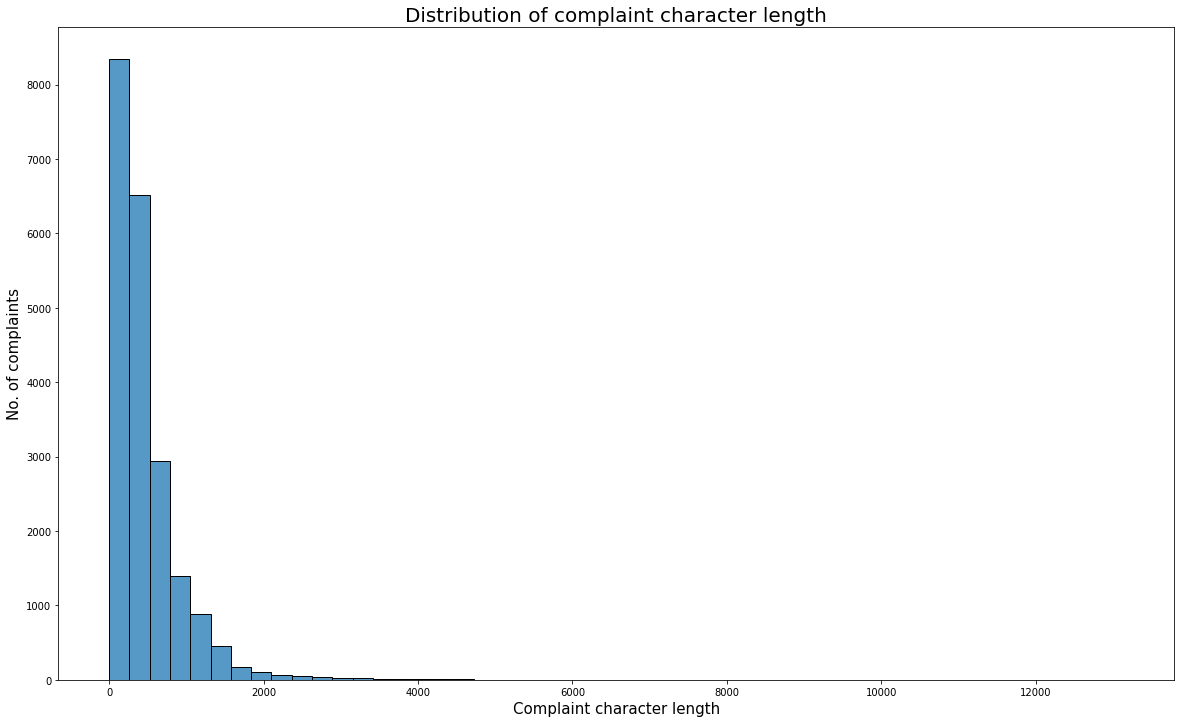

In [ ]:
# Code here to visualise the data according to the 'Complaint' character length:
complaint_length = [len(complaint) for complaint in df_clean["complaint_POS_removed"]]
plt.figure(figsize=[20,12])
sns.histplot(data=complaint_length,bins=50)
plt.title("Distribution of complaint character length", fontsize=20)
plt.xlabel("Complaint character length",size=15)
plt.ylabel("No. of complaints",size=15)

Most of the complaints are no more than 500 characters in length.

#### Find the top 40 words by frequency among all the articles after processing the text.

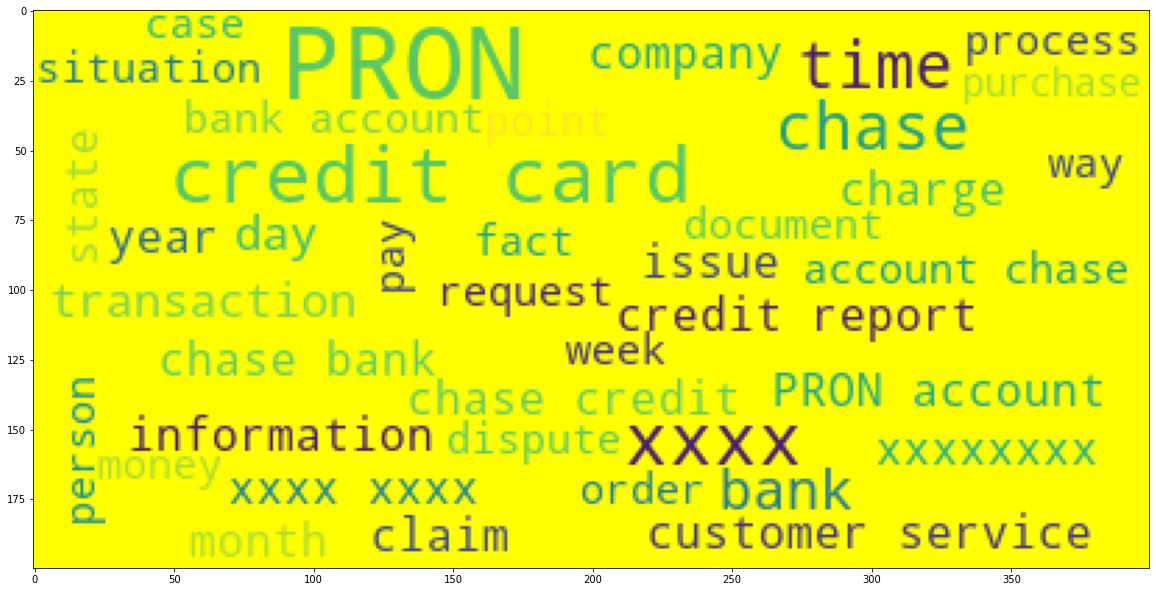

In [ ]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text:
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
    background_color = 'yellow',
    stopwords= stop_words,
    random_state= 42,
    max_words = 40,
    max_font_size= 36
).generate(str(df_clean.complaint_POS_removed))
fig = plt.figure(figsize=(20,12))
plt.imshow(word_cloud)
plt.show()

In [ ]:
# Removing -PRON- from the text corpus:
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# Code to find the top 30 unigram, bigram and trigram frequencies among the complaints in the cleaned datafram(df_clean). 
def get_gram_freq(text,n=30,range=1):
  vec = CountVectorizer(ngram_range=(range,range),stop_words="english").fit(text)
  bag_of_words = vec.transform(text)
  sum_of_words = bag_of_words.sum(axis=0)
  word_frequency = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  word_frequency = sorted(word_frequency, key = lambda x:x[1],reverse=True)
  return word_frequency[:n]

In [ ]:
# Printing the top 10 words in the unigram frequency:
top_unigram_words = get_gram_freq(df_clean['Complaint_clean'])
df_unigram = pd.DataFrame(top_unigram_words,columns=['Unigram','Count'])
df_unigram.head(10)


,Unigram,Count
0,chase,50239
1,account,47181
2,xxxx,35044
3,credit,34149
4,card,29072
5,bank,28390
6,payment,21155
7,time,16024
8,charge,15552
9,day,12970


In [ ]:
# Code to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean):
top_bigram_words = get_gram_freq(df_clean['Complaint_clean'],30,2)
df_bigram = pd.DataFrame(top_bigram_words,columns=['Bigram','Count'])


In [ ]:
# Printing the top 10 words in the bigram frequency:
df_bigram.head(10)

,Bigram,Count
0,credit card,12769
1,credit report,3978
2,xxxx xxxx,3934
3,chase bank,3466
4,customer service,3077
5,chase credit,2962
6,bank account,2768
7,account chase,2672
8,chase account,2391
9,account account,2267


In [ ]:
# Code to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean):
top_trigram_words = get_gram_freq(df_clean['Complaint_clean'],30,3)
df_trigram = pd.DataFrame(top_trigram_words,columns=['Trigram','Count'])

In [ ]:
# Printing the top 10 words in the trigram frequency:
df_trigram.head(10)

,Trigram,Count
0,chase credit card,2030
1,credit card account,1016
2,credit card company,990
3,credit card chase,641
4,xxxx xxxx xxxx,508
5,inquiry credit report,488
6,credit card credit,487
7,charge credit card,452
8,chase customer service,403
9,account credit card,383


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
# All masked texts have been removed:
df_clean.head(10)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card xxxx2018 agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card 2018 agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xxxx2018 notwithstanding my exp

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
# Code to initialise the TfidfVectorizer:
tfidf_vec = TfidfVectorizer(stop_words="english",min_df=2,max_df=0.95)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# Code to create the Document Term Matrix by transforming the complaints column present in df_clean:
dt_matrix = tfidf_vec.fit_transform(df_clean['Complaint_clean'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

Here, we will be using a Gensim library-based coherence scores to determine the ideal number of topics.

In [ ]:
# Importing the Gensim library and its components:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter
from gensim.models import Nmf

In [ ]:
# Executing the Gensim based coherence model to determine the ideal number of topics for classification:
complaints = df_clean['Complaint_clean']
data_complaints = [complaint.split() for complaint in complaints]
dict_complaints = Dictionary(data_complaints)
dict_complaints.filter_extremes(
    keep_n = 5000,
    no_below= 3,
    no_above= 0.85 
)
bow_complaints = [dict_complaints.doc2bow(complaint) for complaint in data_complaints]
topic_numbers = list(np.arange(5,10,1))
coherence_scores = list([])

for number in topic_numbers:
  nmf = Nmf(
        corpus=bow_complaints,
        num_topics=number,
        id2word=dict_complaints,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
  coherence_model = CoherenceModel(
        model= nmf,
        texts= data_complaints,
        dictionary= dict_complaints,
        coherence='u_mass'
    )
  coherence_score = round(coherence_model.get_coherence(),5)
  coherence_scores.append(coherence_score)

In [ ]:
# Printing the ideal number of topics:
scores = list(zip(topic_numbers, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

5


In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=5,random_state=40)

In [ ]:
# Printing the total number of features present:
nmf_model.fit(dt_matrix)
len(tfidf_vec.get_feature_names())

7490

In [ ]:
# Printing the Top15 words for each of the topics:
for idx,topic in enumerate(nmf_model.components_):
  print("Top 15 words for topic #",idx)
  print([tfidf_vec.get_feature_names()[comp] for comp in topic.argsort()[-15:]])
  print("\n")

Top 15 words for topic # 0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'check', 'bank', 'account']


Top 15 words for topic # 1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


Top 15 words for topic # 2
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']


Top 15 words for topic # 3
['company', 'statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'dispute', 'transaction', 'chase', 'fee', 'card', 'charge']


Top 15 words for topic # 4
['car', 'year', 'chase', 'account', 'credit', 'date', 'time', 'auto', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']




In [ ]:
# Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_final = nmf_model.transform(dt_matrix)
topic_final[0].argmax()
topic_final.argmax(axis=1)



array([0, 1, 1, ..., 3, 4, 4])

In [ ]:
# Assigning the best topic to each of the cmplaints in Topic Column:

df_clean['Topic'] = topic_final.argmax(axis=1)

In [ ]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card xxxx2018 agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card 2018 agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xxxx2018 notwithsta

In [ ]:
# Printing the first 5 Complaints for each of the Topics:
df_clean_topicwise=df_clean.groupby('Topic').head(5)
df_clean_topicwise.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
14,my grand son give me check for 160000 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xxxx2018 check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for 160000 i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase 2 time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen xxxx2018 check number xxxx claim number be xxxx with chase,son check deposit -PRON- chase account fund chase bank account money son check money chase bank refuse money son call time i check owner country time date number claim number chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call time i check owner country time date number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday xxxx2019 on thursday xxxx2019 i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday xxxx2019 upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
# Creating the dictionary of Topic names and Topics:

Topic_names = {
    0:'Bank Account Services',
    1:'Credit card or prepaid card',
    2:'Others',
    3:'Theft/Dispute Reporting',
    4:'Mortgage/Loan'
}
#Replacing Topics with Topic Names
df_clean_topicwise.replace({'Topic':Topic_names},inplace=True)

df_clean_topicwise.head(10)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,Bank Account Services
2,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card xxxx2018 agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card 2018 agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no l

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
# Creating the dictionary again of Topic names and Topics:

Topic_names = {
    'Bank Account Services':0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
    }

# Replacing Topics with Topic Names
df_clean_topicwise.replace({'Topic':Topic_names},inplace=True)


In [ ]:
df_clean_topicwise.head(10)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in 2018 i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service i ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in xxxx2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx2018 and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card xxxx2018 agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card 2018 agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on xxxx2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx2019 however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,on xxxx2018 while trying to book a xxxx xxxx ticket i came across an offer for 30000 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xxxx2018 notwithsta

In [ ]:
# Keeping the columns "complaint_what_happened" & "Topic" only in the new dataframe --> training_data:
training_data = df_clean[['complaint_what_happened','Topic']]

Checking the shape of the training data:

In [ ]:
training_data.shape

(21072, 2)

In [ ]:
training_data.Topic.value_counts()

0    5162
1    5022
3    4954
2    3695
4    2239
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [9]:
import pandas as pd

In [13]:
# Code to get the Vector count:
vector_count = CountVectorizer()
x_train_vector_count = vector_count.fit_transform(training_data['complaint_what_happened'])

In [14]:
# Code to transform the word vector to tf-idf:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(x_train_vector_count)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [15]:
# Libraries for model evaluation metrics:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [16]:
# Train-Test data split:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 36501)
y_train Shape: (15804,)
X_test Shape: (5268, 36501)
y_test Shape: (5268,)


Writing a common function to evaluate models using the metrics:


1.   Classification report.
2.   Confusion matrix.



In [17]:
# Function for classification model evaluation:
def model_eval(y_test, y_pred, model_name):
    # Confusion matrix display logic:
    plt.figure(figsize=(20,15))
    plt.title(f"Confusion Matrix for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

        # Classification report display logic:
    print(f"Classification report for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    
    return



## 1.   Logistic Regression Model:



In [18]:
# Importing the required library:
from sklearn.linear_model import LogisticRegression

In [19]:
model_name = 'Logistic Regression'
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [19]:
# Tuning the hyperparameters for getting the best model:
params_log_reg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_log_reg = GridSearchCV(estimator=lr, 
                       param_grid=params_log_reg,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_log_reg.fit(X_train, y_train)
print(grid_log_reg.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [20]:
# Creating the logistic regression model with the best parameters:

log_reg_best = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

log_reg_best.fit(X_train, y_train)
y_pred_lr_best = log_reg_best.predict(X_test)

In [21]:
# F1 score calculation:
f1_log_reg = f1_score(y_test, y_pred_lr_best, average="weighted")
print("F1 Score using logistic regression model :",f1_log_reg)

F1 Score using logistic regression model : 0.9426431513858614


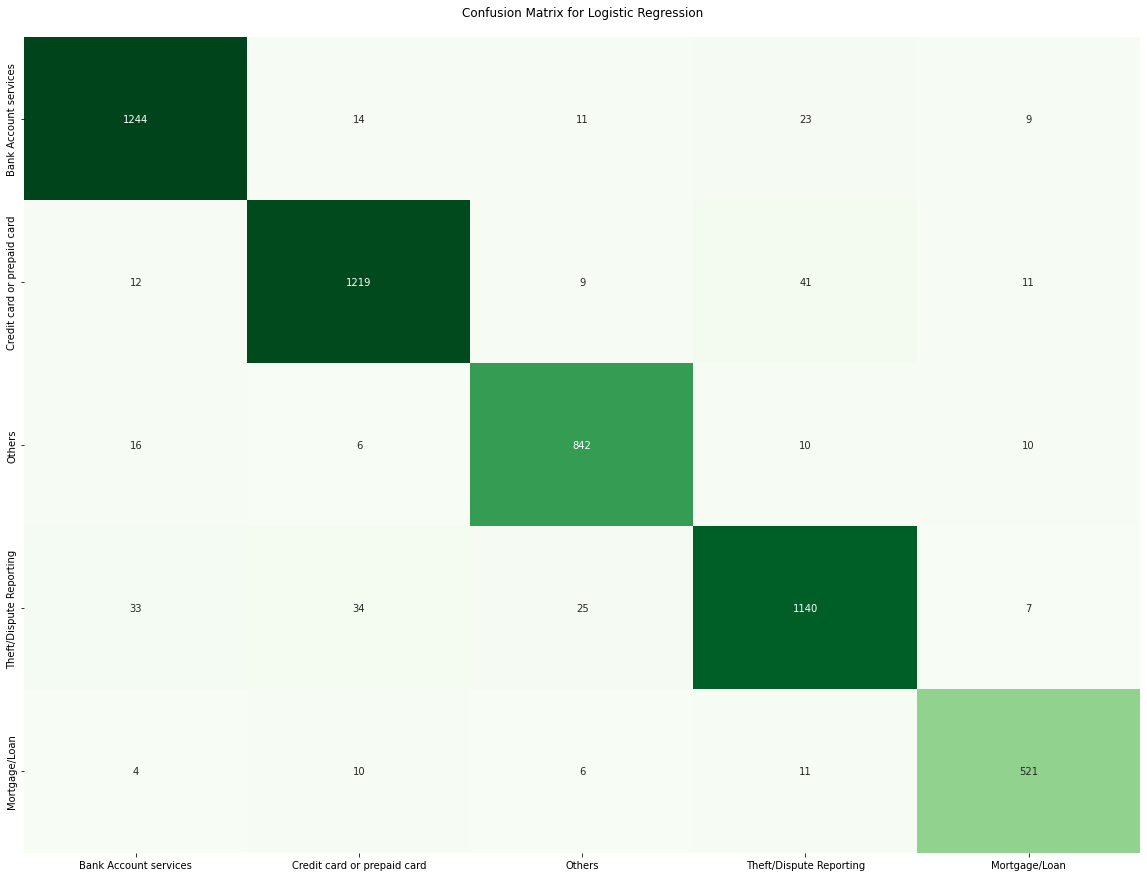

Classification report for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1301
Credit card or prepaid card       0.95      0.94      0.95      1292
                     Others       0.94      0.95      0.95       884
    Theft/Dispute Reporting       0.93      0.92      0.93      1239
              Mortgage/Loan       0.93      0.94      0.94       552

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



In [22]:
# Model evaluation:
model_eval(y_test, y_pred_lr_best, model_name)

## 2.   Decision Tree Model




In [23]:
# Importing the necessary library:
from sklearn.tree import DecisionTreeClassifier

In [24]:
model_name = 'Decision Tree'
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt =dt_model.predict(X_test)

In [25]:
# Decision tree hyperparameter tuning:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt_model = GridSearchCV(estimator=dt_model, 
                       param_grid=params_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt_model.fit(X_train, y_train)
print(grid_dt_model.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 10}


In [32]:
# Predicting using the best decision tree model:
dt_model_best = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=10, 
                                      )
dt_model_best.fit(X_train, y_train)
y_pred_dt_best = dt_model_best.predict(X_test)

In [33]:
# F1 Score Calculation:
f1_dt_best = f1_score(y_test, y_pred_dt_best, average="weighted")
print("F1 score using the best decision tree model: ",f1_dt_best)


F1 score using the best decision tree model:  0.7936287744195899


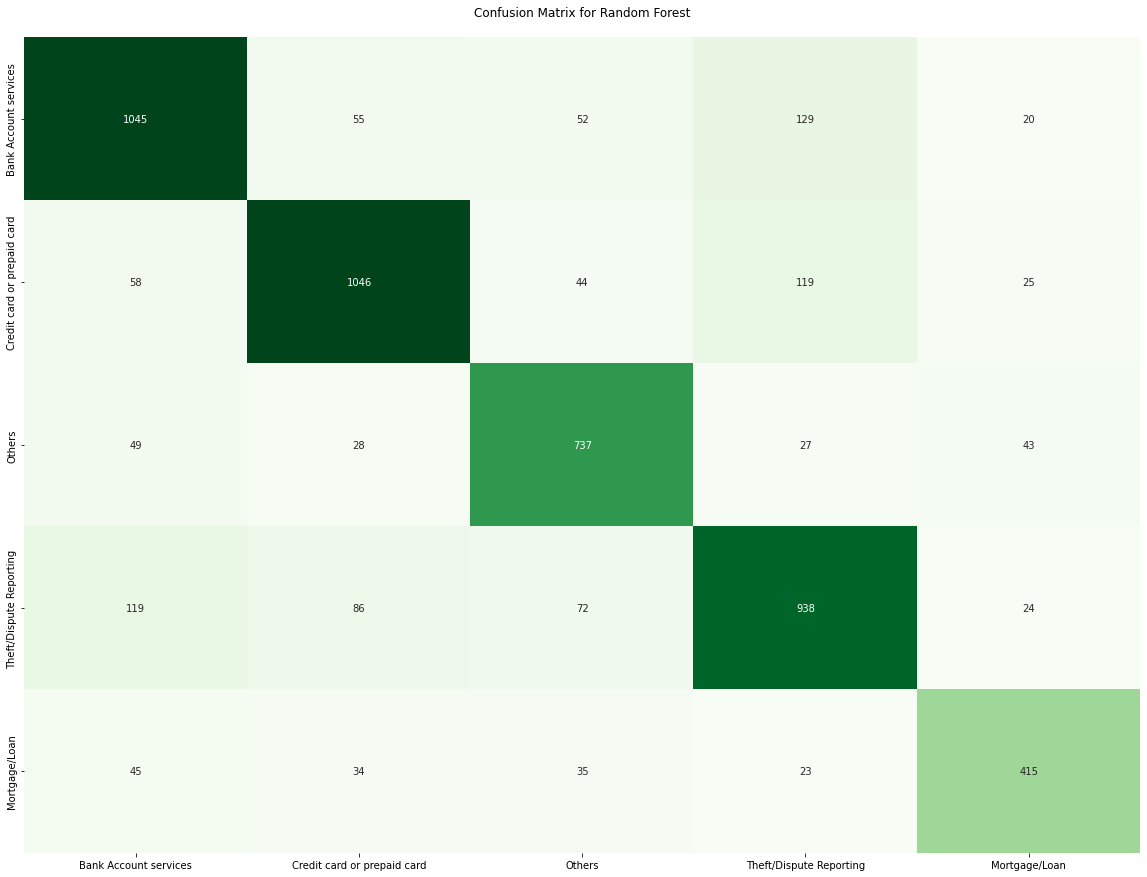

Classification report for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.80      0.80      1301
Credit card or prepaid card       0.84      0.81      0.82      1292
                     Others       0.78      0.83      0.81       884
    Theft/Dispute Reporting       0.76      0.76      0.76      1239
              Mortgage/Loan       0.79      0.75      0.77       552

                   accuracy                           0.79      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



In [34]:
# Model evaluation:
model_eval(y_test, y_pred_dt_best, model_name)

## 3.   Random Forest Model


In [35]:
# Import the required library:
from sklearn.ensemble import RandomForestClassifier

In [36]:
model_name = 'Random Forest'
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf =rf_model.predict(X_test)

In [42]:
# Random forest hyperparameter tuning:
params_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50]
    
}

grid_rf_model = GridSearchCV(estimator=rf_model, 
                       param_grid=params_rf,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_rf_model.fit(X_train, y_train)
print(grid_rf_model.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}


In [43]:
# Predicting using the best random forest model:
rf_model_best = RandomForestClassifier(criterion='gini', 
                                      max_depth=10, 
                                      min_samples_leaf=5,
                                      n_estimators=50, 
                                      )
rf_model_best.fit(X_train, y_train)
y_pred_rf_best = rf_model_best.predict(X_test)

In [44]:
# F1 Score Calculation:
f1_rf_best = f1_score(y_test, y_pred_rf_best, average="weighted")
print("F1 score using the best random forest model: ",f1_rf_best)


F1 score using the best random forest model:  0.6641227642341125


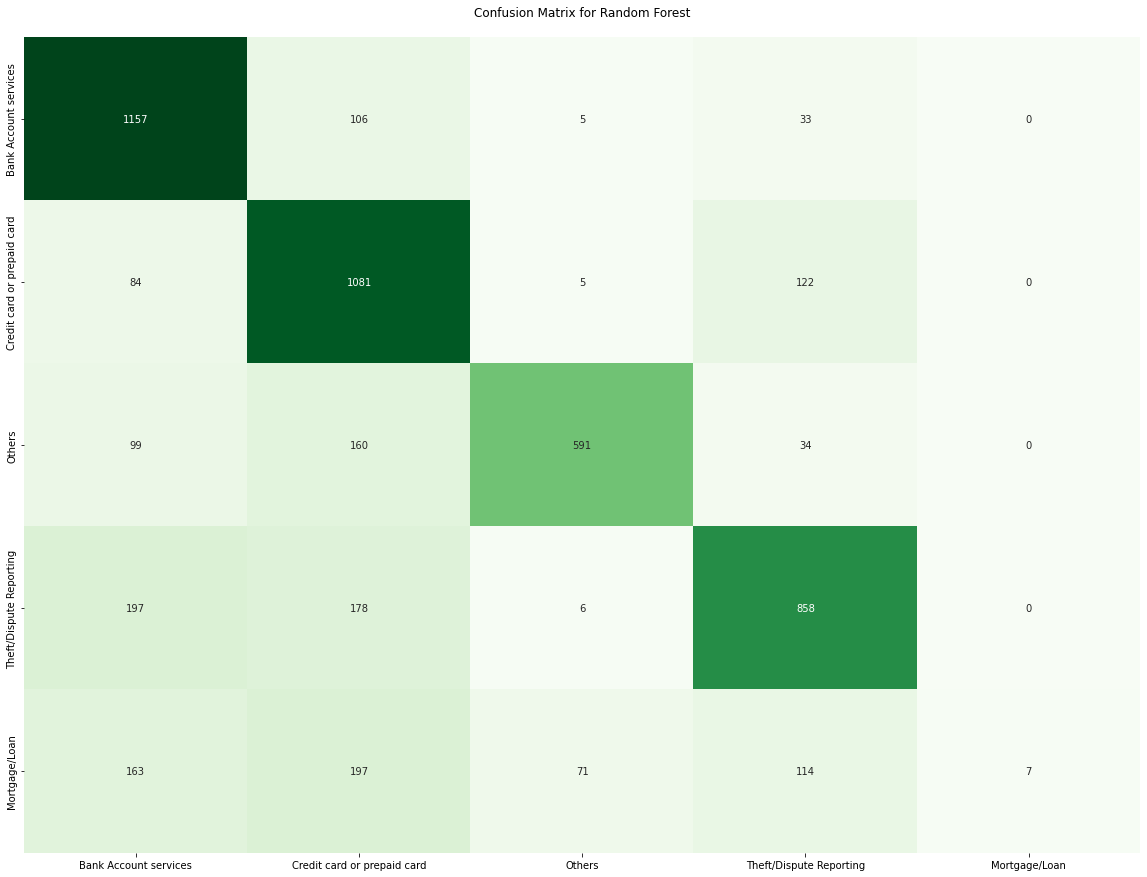

Classification report for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.68      0.89      0.77      1301
Credit card or prepaid card       0.63      0.84      0.72      1292
                     Others       0.87      0.67      0.76       884
    Theft/Dispute Reporting       0.74      0.69      0.72      1239
              Mortgage/Loan       1.00      0.01      0.03       552

                   accuracy                           0.70      5268
                  macro avg       0.78      0.62      0.60      5268
               weighted avg       0.75      0.70      0.66      5268



In [45]:
# Model evaluation:
model_eval(y_test, y_pred_rf_best, model_name)

## 4.   Naive Bayes Model


In [46]:
# Importing the required library:
from sklearn.naive_bayes import MultinomialNB

In [47]:
# Executing the model with the default parameters:
model_name = 'Naive Bayes'
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [48]:
# Hyperparameter tuning:
params_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb_model = GridSearchCV(estimator=nb_model, 
                       param_grid=params_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb_model.fit(X_train, y_train)
print(grid_nb_model.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [49]:
# Model execution with the best parameters:
nb_model_best = MultinomialNB(alpha=0.1,fit_prior=False)
nb_model_best.fit(X_train, y_train)
y_pred_nb_best = nb_model_best.predict(X_test)

In [50]:
# F1 Score Calculation:
f1_nb = f1_score(y_test, y_pred_nb_best, average="weighted")
print("F1 Score for the best Naive Bayes model: ",f1_nb)

F1 Score for the best Naive Bayes model:  0.7817873566366589


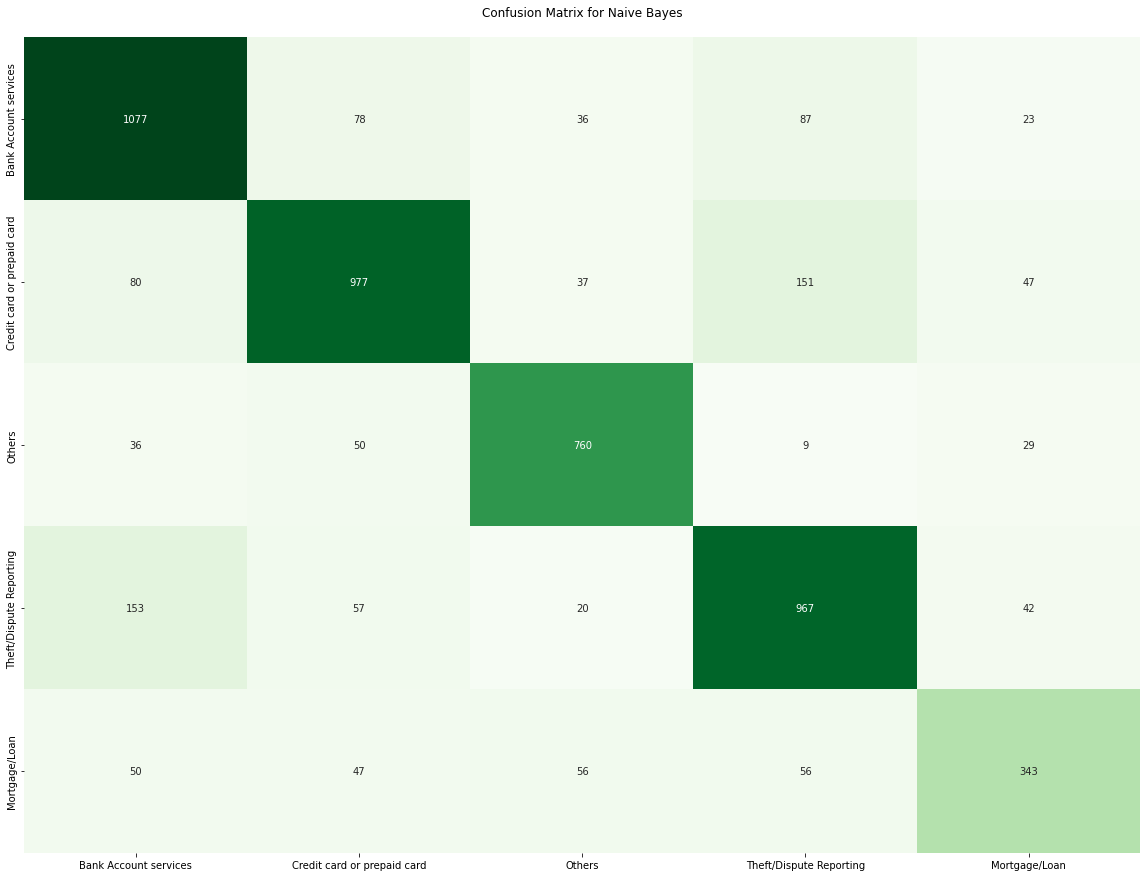

Classification report for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.83      0.80      1301
Credit card or prepaid card       0.81      0.76      0.78      1292
                     Others       0.84      0.86      0.85       884
    Theft/Dispute Reporting       0.76      0.78      0.77      1239
              Mortgage/Loan       0.71      0.62      0.66       552

                   accuracy                           0.78      5268
                  macro avg       0.78      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



In [51]:
# Model evaluation:
model_eval(y_test, y_pred_nb_best, model_name)

# From the above 4 models built, the <b><u>logistic regression model</b></u> performed the best overall in terms of all the evaluation metrics i.e precision, recall, F1 score etc. Thus the best performing model is the <b><u>logistic regression model</b></u>.

## Executing the selected classification model against custom text:

In [33]:
# Function to predict a topic for custom text:

def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    X_new_count = vector_count.transform([text])
    X_new_tfidf = tfidf_transformer.transform(X_new_count)
    prediction = log_reg_best.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [54]:
# Creating the custom text:
df_custom_text = pd.DataFrame({'Complaints':[
                                             "How to calculate my CIBIL score?",
                                             "An unwanted service was activated and my money deducted automatically",
                                             "My loan amount disbursal is delayed. What is the issue?", 
                                             "Where are the bank branches in Bangalore?",
                                             "I want to open a salary account at your branch. Please share the procedure.",
                                             "My credit card was debited twice. Please look into the matter and resolve it as soon as possible. Thanks."]})
df_custom_text

,Complaints
0,How to calculate my CIBIL score?
1,An unwanted service was activated and my money deducted automatically
2,My loan amount disbursal is delayed. What is the issue?
3,Where are the bank branches in Bangalore?
4,I want to open a salary account at your branch. Please share the procedure.
5,My credit card was debited twice. Please look into the matter and resolve it as soon as possible. Thanks.


In [55]:
# Using the best model to predict the topic:
df_custom_text['Predicted Topic'] = df_custom_text.apply(lambda x: predict_topic(x['Complaints']), axis=1)

In [56]:
# Viewing the predicted topics:
df_custom_text

,Complaints,Predicted Topic
0,How to calculate my CIBIL score?,Others
1,An unwanted service was activated and my money deducted automatically,Bank Account services
2,My loan amount disbursal is delayed. What is the issue?,Others
3,Where are the bank branches in Bangalore?,Bank Account services
4,I want to open a salary account at your branch. Please share the procedure.,Bank Account services
5,My credit card was debited twice. Please look into the matter and resolve it as soon as possible. Thanks.,Credit card or prepaid card


## The best model has predicted the complaint category correctly in most cases.